In [2]:
import pandas as pd

# Load your real dataset
df = pd.read_csv('../data/processed/similarity_with_returns.csv')

# Preview the data
print(df.head())

df

      cik  tic       month  similarity_score     ret
0  200406  jnj  2012-05-31          0.982833 -3.1644
1  200406  jnj  2012-08-31          0.979335 -1.7047
2  200406  jnj  2012-11-30          0.992482 -0.6778
3  200406  jnj  2013-02-28          0.987755  3.7879
4  200406  jnj  2013-05-31          0.989229 -0.4576


,cik,tic,month,similarity_score,ret
0,200406,jnj,2012-05-31,0.982833,-3.1644
1,200406,jnj,2012-08-31,0.979335,-1.7047
2,200406,jnj,2012-11-30,0.992482,-0.6778
3,200406,jnj,2013-02-28,0.987755,3.7879
4,200406,jnj,2013-05-31,0.989229,-0.4576
...,...,...,...,...,...
77,1652044,goog,2016-02-29,0.978489,-5.7963
78,1652044,goog,2016-03-31,0.926402,6.3690
79,1652044,goog,2016-05-31,0.897723,5.7877
80,1652044,goog,2016-08-31,0.996488,-0.1883


In [3]:
# Assign quintiles within each month using similarity_score
def assign_quintile(x):
    if len(x) < 5:
        max_signal = x['similarity_score'].max()
        min_signal = x['similarity_score'].min()
        return x['similarity_score'].apply(lambda s: 5 if s == max_signal else (1 if s == min_signal else 3))
    else:
        return pd.qcut(x['similarity_score'], 5, labels=[1,2,3,4,5])

df['quintile'] = df.groupby('month', group_keys=False).apply(assign_quintile).astype(int)

/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_17219/771229645.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['quintile'] = df.groupby('month', group_keys=False).apply(assign_quintile).astype(int)


In [4]:
df

,cik,tic,month,similarity_score,ret,quintile
0,200406,jnj,2012-05-31,0.982833,-3.1644,5
1,200406,jnj,2012-08-31,0.979335,-1.7047,5
2,200406,jnj,2012-11-30,0.992482,-0.6778,5
3,200406,jnj,2013-02-28,0.987755,3.7879,5
4,200406,jnj,2013-05-31,0.989229,-0.4576,5
...,...,...,...,...,...,...
77,1652044,goog,2016-02-29,0.978489,-5.7963,1
78,1652044,goog,2016-03-31,0.926402,6.3690,5
79,1652044,goog,2016-05-31,0.897723,5.7877,1
80,1652044,goog,2016-08-31,0.996488,-0.1883,5


In [4]:
#Compute monthly long-short portfolio returns
portfolio_rets = []
for month, group in df.groupby('month'):
    long_ret = group.loc[group['quintile'] == 5, 'ret'].mean()
    short_ret = group.loc[group['quintile'] == 1, 'ret'].mean()
    long_short = long_ret - short_ret
    portfolio_rets.append({'month': month, 'portfolio_return': long_short})

portfolio_df = pd.DataFrame(portfolio_rets)
portfolio_df['month'] = pd.to_datetime(portfolio_df['month'])
portfolio_df = portfolio_df.sort_values('month')

In [5]:
#Calculate cumulative return (growth of $1, if ret is percent, convert to decimal first)
portfolio_df['portfolio_return_decimal'] = portfolio_df['portfolio_return'] / 100
portfolio_df['cum_portfolio'] = (1 + portfolio_df['portfolio_return_decimal']).cumprod()


In [20]:
#Output your results
print(portfolio_df.head())
# Save your portfolio DataFrame as a CSV file in the right path
portfolio_df.to_csv("/Users/lhn/Desktop/FIN377/lazy-prices_replication/data/processed/step9_portfolio_returns.csv", index=False)


       month  portfolio_return  portfolio_return_decimal  cum_portfolio
0 2012-01-31               NaN                       NaN            NaN
1 2012-04-30            15.257                   0.15257       1.152570
2 2012-05-31               NaN                       NaN            NaN
3 2012-07-31             5.829                   0.05829       1.219753
4 2012-08-31               NaN                       NaN            NaN


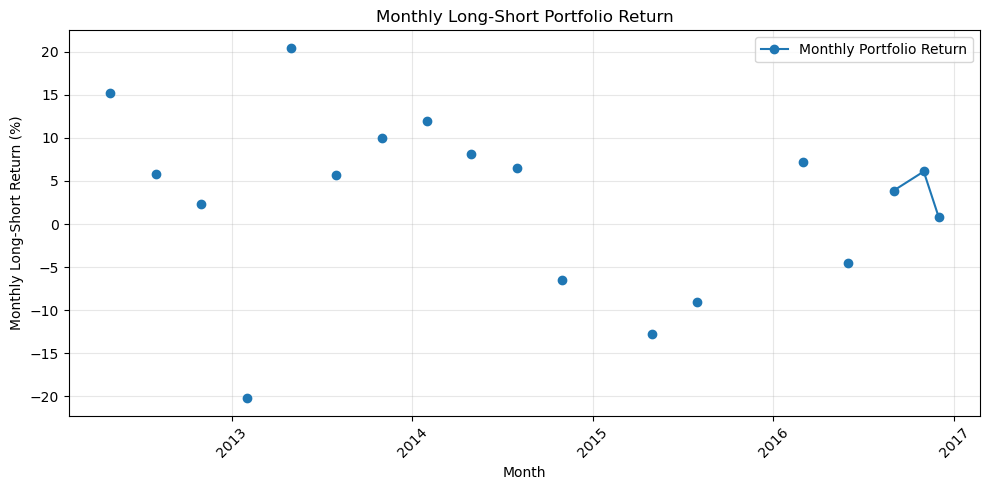

In [10]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(portfolio_df['month'], portfolio_df['portfolio_return'], marker='o', label='Monthly Portfolio Return')
plt.xlabel('Month')
plt.ylabel('Monthly Long-Short Return (%)')
plt.title('Monthly Long-Short Portfolio Return')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [16]:
# S&P 500
import pandas as pd

# Download S&P 500 from FRED
fred_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=SP500"
sp500 = pd.read_csv(fred_url)

# Check real column names
print(sp500.columns)
# Likely: ['observation_date', 'SP500']

# Convert date and rename for consistency
sp500['month'] = pd.to_datetime(sp500['observation_date'])
sp500 = sp500.rename(columns={'SP500':'sp500_index'})

# Filter to your project range
start_date = "2012-01-01"
end_date = "2016-11-30"
sp500 = sp500[(sp500['month'] >= start_date) & (sp500['month'] <= end_date)]

# Calculate monthly returns (in percent)
sp500['sp500_return'] = sp500['sp500_index'].pct_change() * 100

# Format date as string if merging
sp500['month'] = sp500['month'].dt.strftime('%Y-%m-%d')

# Drop first row with NaN return
sp500 = sp500.dropna(subset=['sp500_return'])

print(sp500[['month', 'sp500_return']].head())

Index(['observation_date', 'SP500'], dtype='object')
        month  sp500_return
1  2015-04-28      0.276919
2  2015-04-29     -0.374038
3  2015-04-30     -1.012887
4  2015-05-01      1.092299
5  2015-05-04      0.294077


/var/folders/0l/qx_t59gs2g159dkl9zybv6f40000gn/T/ipykernel_15727/2788594281.py:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp500['sp500_return'] = sp500['sp500_index'].pct_change() * 100


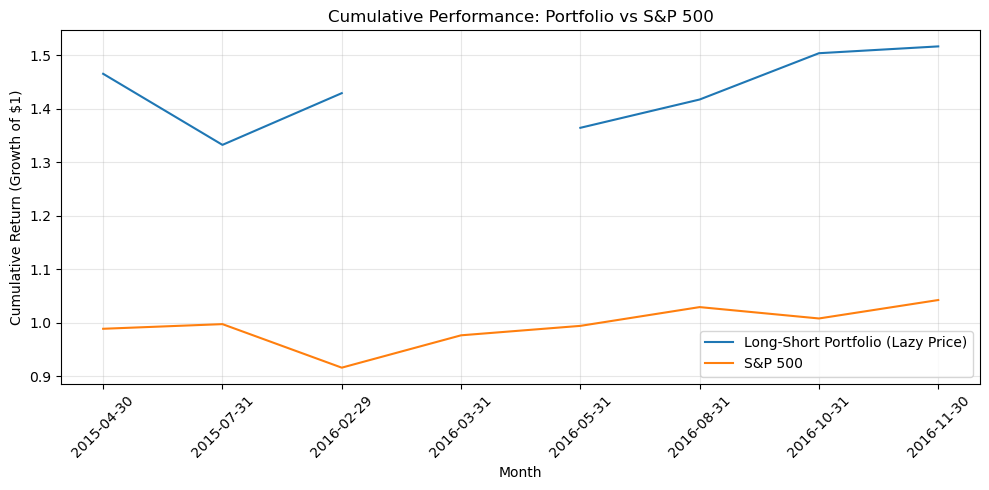

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your saved portfolio results (from CSV)
portfolio_df = pd.read_csv("/Users/lhn/Desktop/FIN377/lazy-prices_replication/data/processed/step9_portfolio_returns.csv")
portfolio_df['month'] = pd.to_datetime(portfolio_df['month']).dt.strftime('%Y-%m-%d')

# 2. S&P 500 already loaded and processed as `sp500`
# (from your previous notebook cell using FRED URL)
# sp500['month'] and sp500['sp500_return'] are ready

# 3. Calculate cumulative returns for both
# Portfolio
if 'cum_portfolio' not in portfolio_df.columns:
    portfolio_df['portfolio_return_decimal'] = portfolio_df['portfolio_return'] / 100
    portfolio_df['cum_portfolio'] = (1 + portfolio_df['portfolio_return_decimal']).cumprod()
# S&P 500
sp500['sp500_return_decimal'] = sp500['sp500_return'] / 100
sp500['cum_sp500'] = (1 + sp500['sp500_return_decimal']).cumprod()

# 4. Merge on 'month'
merged = pd.merge(
    portfolio_df[['month', 'cum_portfolio']],
    sp500[['month', 'cum_sp500']],
    on='month', how='inner'
)



# 6. Plot
plt.figure(figsize=(10,5))
plt.plot(merged['month'], merged['cum_portfolio'], label='Long-Short Portfolio (Lazy Price)')
plt.plot(merged['month'], merged['cum_sp500'], label='S&P 500')
plt.xlabel('Month')
plt.ylabel('Cumulative Return (Growth of $1)')
plt.title('Cumulative Performance: Portfolio vs S&P 500')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Logic
1.
a. Sort all firms by their similarity_score for that month (the higher the score, the more “similar” their filing is to the previous one).
b. Assign quintiles (divide into 5 groups) based on the similarity_score within that month:
Top 20% (5th quintile): Firms with the highest similarity
Bottom 20% (1st quintile): Firms with the lowest similarity
2.
Long leg: Go long (buy) all stocks in the top quintile (highest similarity).
Short leg: Go short (sell) all stocks in the bottom quintile (lowest similarity).

Returns are equally weighted within each leg (i.e., average the returns for the long group and the short group).
3.
Long-short return = Mean(return of long leg) - Mean(return of short leg)

Key
If the long-short return is consistently positive:It means firms with high similarity (i.e., "lazy" prices) tend to outperform those with low similarity, after controlling for general market movements.
